In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings 
warnings.simplefilter("ignore")

### 数据分析 数据预处理
对以下来自不同物种生物的 DNA 密码子 (codon) 使用频率数据进行数据挖掘 (Data Mining), 包括数据探索 (Exploration)、数据预处理 (Preprocessing)、分类 (Clas- sification) 或聚类 (Clustering) 等。简要数据说明: 这个数据集是不同物种生物的 DNA 密码子的使用频率数据. 该数据集来自 CUTG 数据库, 并做了适当修改. 现该数据集内每条数据的 69 个属性如下:\
1 - Kingdom: 物种, 是由 3 个字母构成, 包括 11 个物种;\
2 - DNAtype: 基因组, 是 1 个整数标记, 包括 13 种构成;\
3 - SpeciesID: 物种 ID, 是 1 个整数标记, 原始 CUTG 数据库的物种标识;\
4 - Ncodons: 密码子总数, 是 1 个整数;\
5 - SpeciesName: 物种名称, 是 1 串字符串;\
6-69 密码子使用频率 (frequency of usage), 是 1 个 5 位小数的浮点数, 核苷酸碱基包括 'UUU', 'UUA', 'UUG', 'CUU', 等.

In [35]:
data = pd.read_csv('codon_usage.csv',low_memory=False)
data = data.set_index('SpeciesID')
data.head()

,Kingdom,DNAtype,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
SpeciesID,,,,,,,,,,,,,,,,,,,,,
100217,vrl,0,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
100220,vrl,0,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
100755,vrl,0,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
100880,vrl,0,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
100887,vrl,0,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


数据基本信息：不存在空值、异常值。注意到 ‘uuu’ 与 ’uuc‘列的dtype 为object， 可能存在异常数据类型。尝试将其更改为数值类型来寻找异常\
data['UUU']=data['UUU'].replace(['non-B hepatitis virus','12;I'],'NaN')\
data['UUC']=data['UUC'].replace('-','NaN')

In [9]:
data[(data['UUU'] == 'non-B hepatitis virus') | (data['UUC'] == '-')]

,Kingdom,DNAtype,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
SpeciesID,,,,,,,,,,,,,,,,,,,,,
12440,vrl,0,1238,Non-A,non-B hepatitis virus,0.04362,0.0210,0.01292,0.01292,0.03554,...,0.00081,0.00323,0.00242,0.00162,0.04443,0.01696,0.02423,0.02262,0.00162,0.00000
353569,bct,0,1698,Salmonella enterica subsp. enterica serovar 4,12;I,-,0.0212,0.02356,0.01178,0.01296,...,0.03062,0.00118,0.00707,0.00118,0.00000,0.02945,0.02356,0.04476,0.02473,0.00118


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13028 entries, 100217 to 9606
Data columns (total 68 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   Ncodons      13028 non-null  int64  
 3   SpeciesName  13028 non-null  object 
 4   UUU          13028 non-null  object 
 5   UUC          13028 non-null  object 
 6   UUA          13028 non-null  float64
 7   UUG          13028 non-null  float64
 8   CUU          13028 non-null  float64
 9   CUC          13028 non-null  float64
 10  CUA          13028 non-null  float64
 11  CUG          13028 non-null  float64
 12  AUU          13028 non-null  float64
 13  AUC          13028 non-null  float64
 14  AUA          13028 non-null  float64
 15  AUG          13028 non-null  float64
 16  GUU          13028 non-null  float64
 17  GUC          13028 non-null  float64
 18  GUA          13028 non-null  float64
 19  GUG  

In [3]:
data['UUU'] = pd.to_numeric(data['UUU'], errors='coerce')
data['UUC'] = pd.to_numeric(data['UUC'], errors='coerce')
data.dropna(inplace=True)
codon_describe = data.describe().iloc[:, 2:]
codon_describe

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,...,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000
mean,0.024818,0.023440,0.020637,0.014104,0.017821,0.018287,0.019045,0.018452,0.028355,0.025038,...,0.005453,0.009930,0.006423,0.024181,0.021164,0.028291,0.021683,0.001640,0.000590,0.006179
std,0.017628,0.011598,0.020710,0.009280,0.010587,0.014573,0.024252,0.016578,0.017507,0.014596,...,0.006601,0.008574,0.006388,0.013826,0.013039,0.014343,0.015019,0.001785,0.000882,0.010345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013910,0.015380,0.005610,0.007103,0.010890,0.007830,0.005302,0.007180,0.016370,0.015130,...,0.001220,0.001690,0.001170,0.012390,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009680,0.012800,0.025480,0.021540,...,0.003530,0.009270,0.004545,0.025425,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,0.031308,0.029210,0.029495,0.019808,0.022730,0.025110,0.017255,0.024325,0.038117,0.031860,...,0.007150,0.015928,0.010250,0.034190,0.027690,0.036800,0.031128,0.002370,0.000830,0.002890
max,0.217300,0.091690,0.151330,0.101190,0.089780,0.100350,0.163920,0.107370,0.154060,0.088600,...,0.055540,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700


In [36]:
# 集成学习方法 random forest

X, y = data.drop(['Kingdom', 'DNAtype', 'Ncodons','SpeciesName'], axis=1), data['Kingdom']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

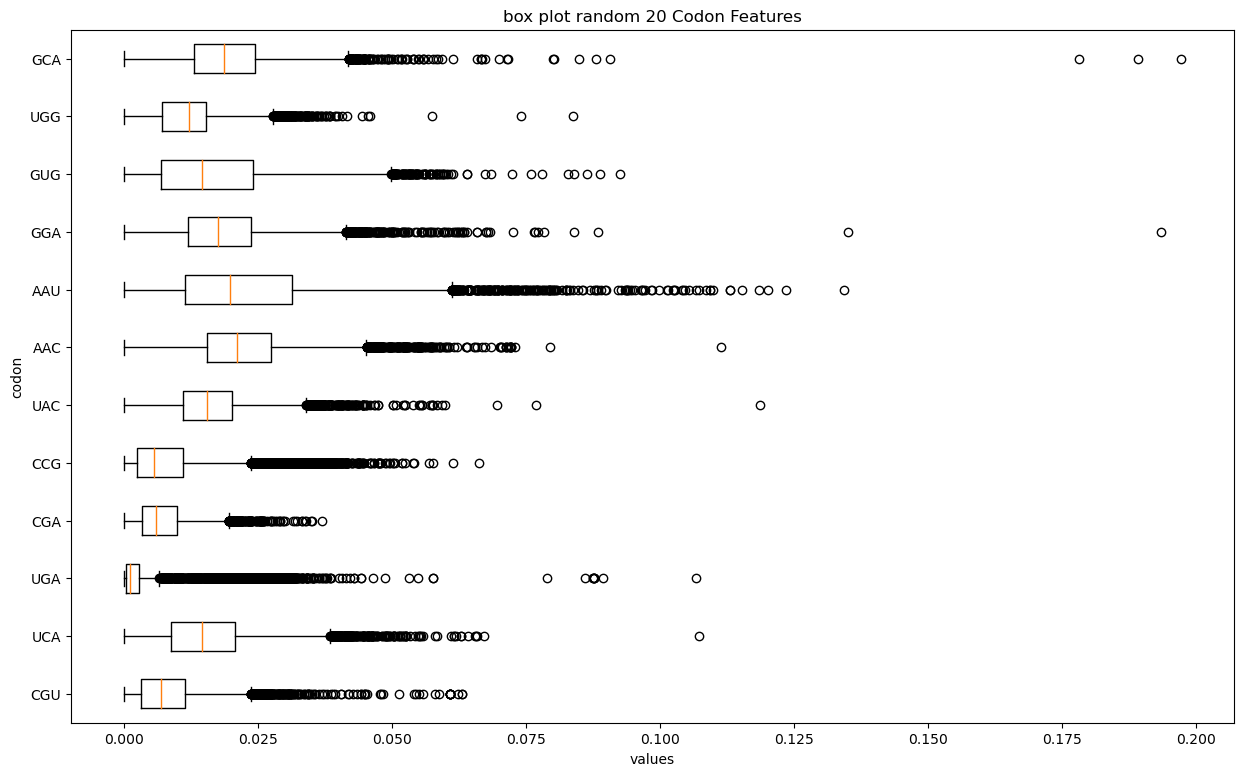

In [13]:
np.random.seed(123)
plt.figure(figsize = (15,9))
ind = np.arange(X.shape[1])
np.random.shuffle(ind)

plt.boxplot(X.iloc[:, ind[0:12]].values, vert=False, labels=X.iloc[:, ind[0:12]].columns)
# 设置图表标题和标签
plt.title('box plot random 20 Codon Features')
plt.xlabel('values')
plt.ylabel('codon')

# 显示图表
plt.savefig('boxplot.png')
plt.show()

<Figure size 1500x900 with 0 Axes>

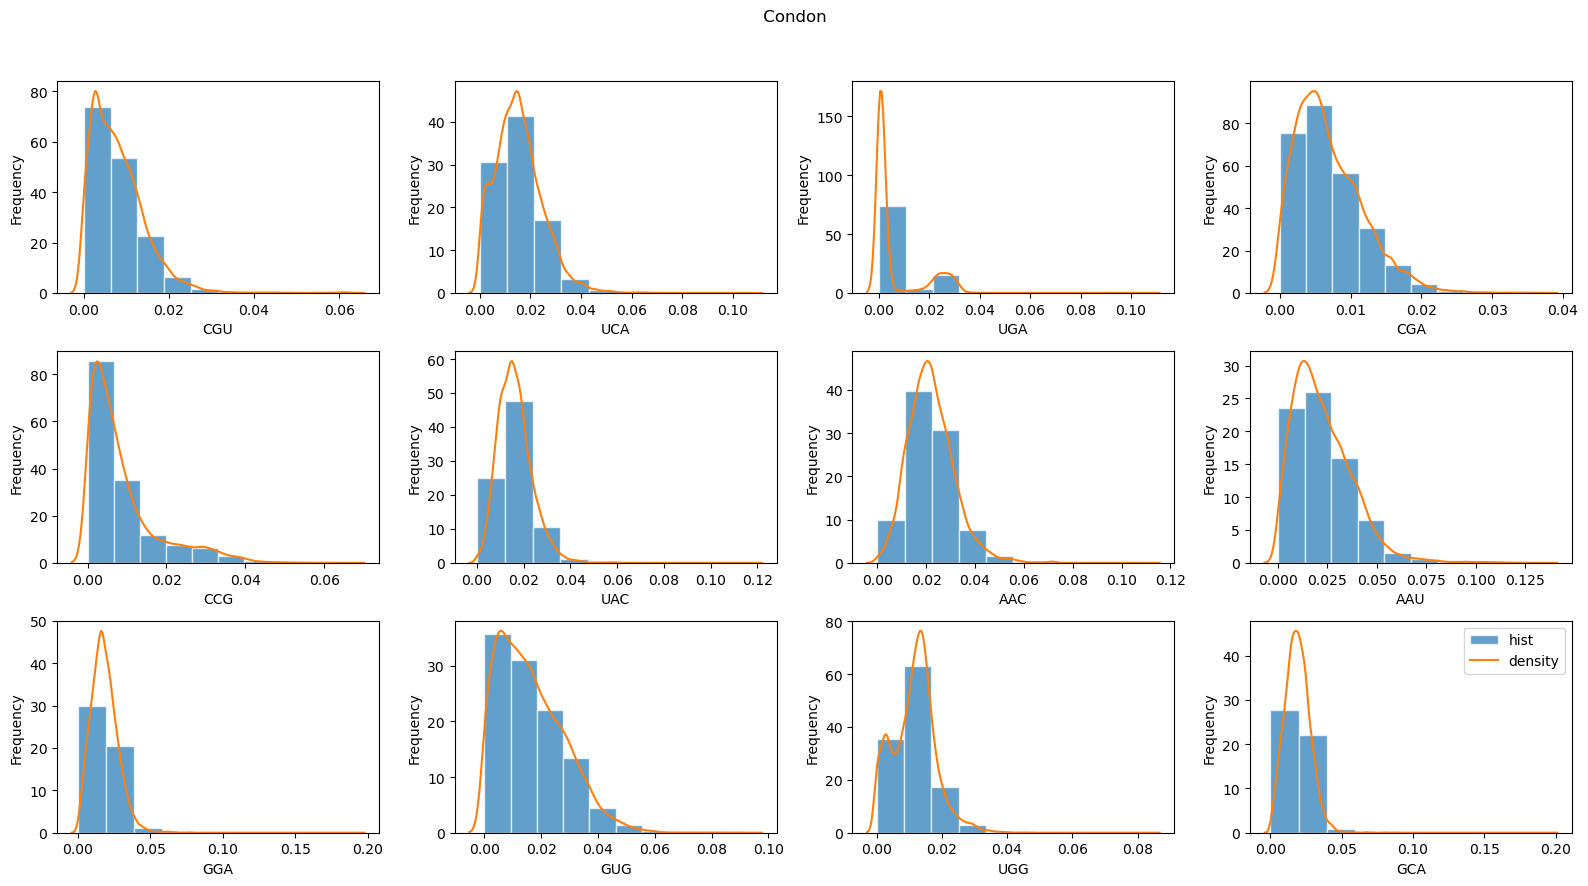

In [14]:
np.random.seed(123)
plt.figure(figsize = (15,9))
ind = np.arange(X.shape[1])

np.random.shuffle(ind)

fig, axes = plt.subplots(3, 4, figsize=(16, 9))


# plot the histograms
for i, ax in enumerate(axes.flatten()):
    column_name = X.columns[ind[i]]
    ax.hist(X[column_name],density = True,edgecolor ='w', alpha=0.7,label = 'hist')
    sns.kdeplot(X[column_name],label = 'density',ax = ax) 
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    
#adjust the layout
plt.tight_layout()
# graphics display
plt.suptitle(' Condon ', fontsize=12)
plt.subplots_adjust(top=0.9)
plt.legend()
#plt.savefig('histogram.png')
plt.show()

In [15]:
data[data['UUU'] > 0.15]

,Kingdom,DNAtype,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
SpeciesID,,,,,,,,,,,,,,,,,,,,,
36090,inv,1,2169,mitochondrion Globodera pallida,0.21485,0.02766,0.05994,0.05671,0.03827,0.00968,...,0.00415,0.01245,0.02259,0.01521,0.00645,0.00738,0.01291,0.00184,0.00184,0.00645
5657,inv,1,1029,mitochondrion Crithidia oncopelti,0.17590,0.01166,0.09718,0.02721,0.01166,0.00097,...,0.00000,0.00292,0.00194,0.02624,0.00486,0.00777,0.00097,0.00194,0.00000,0.02041
5689,inv,12,2179,kinetoplast Leishmania tarentolae,0.15282,0.01056,0.10509,0.01514,0.00826,0.00321,...,0.00184,0.00688,0.00046,0.02708,0.01193,0.00872,0.00964,0.00229,0.00138,0.01560
5710,inv,1,1200,mitochondrion Trypanoplasma borreli,0.15167,0.00583,0.10667,0.04000,0.01250,0.00083,...,0.00000,0.01083,0.00250,0.02417,0.00583,0.01583,0.00000,0.00250,0.00083,0.02000
6248,inv,1,2913,mitochondrion Strongyloides stercoralis,0.21730,0.00927,0.05287,0.04016,0.02746,0.00000,...,0.00034,0.00412,0.00069,0.02197,0.00069,0.00515,0.00858,0.00275,0.00069,0.01030
6279,inv,1,2522,mitochondrion Brugia malayi,0.17407,0.00476,0.06225,0.05115,0.00674,0.00040,...,0.00238,0.00595,0.00436,0.02498,0.00198,0.00753,0.00912,0.00198,0.00159,0.01031
6282,inv,1,3469,mitochondrion Onchocerca volvulus,0.17873,0.00144,0.04007,0.08735,0.00749,0.00058,...,0.00288,0.00375,0.00778,0.02364,0.00029,0.00605,0.01297,0.00144,0.00202,0.00836
6287,inv,1,2460,mitochondrion Dirofilaria immitis,0.19268,0.00081,0.03415,0.08740,0.00732,0.00000,...,0.00203,0.00447,0.00488,0.02520,0.00041,0.00366,0.01138,0.00122,0.00203,0.00813
90914,inv,1,1230,mitochondrion Paratomella rubra,0.15935,0.00650,0.10732,0.02276,0.01220,0.00163,...,0.00081,0.01057,0.01138,0.01626,0.00081,0.01057,0.01707,0.00325,0.00081,0.01138


### classification and clustering
Features: condon frequency of usage. 事实上 Kingdom 和 DNA type 都可以用于做分类测试的目标, 但DNAtype极端 unbalanced，考虑Kingdom 的多分类预测问题。

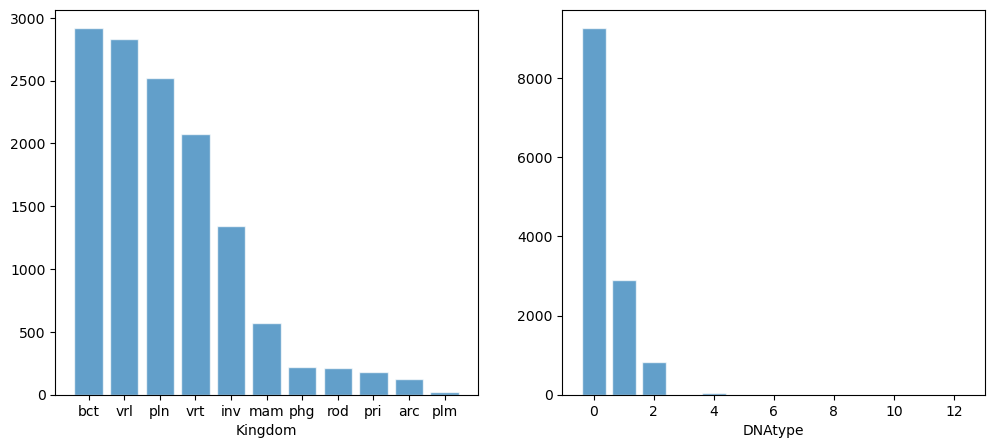

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
columns = ['Kingdom', 'DNAtype']
for i, ax in enumerate(axes.flatten()):
    column = columns[i]
    class_counts = data[column].value_counts()
    ax.bar(class_counts.index, class_counts.values,edgecolor ='w', alpha=0.7,label = 'hist')
    ax.set_xlabel(column)
plt.show()

In [18]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on train data: {:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy on test data: {:.4f}".format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
#target_names = list(data['Kingdom'].unique())

print(classification_report(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

Accuracy on train data: 1.0000
Accuracy on test data: 0.8932
              precision    recall  f1-score   support

         arc       0.82      0.35      0.49        26
         bct       0.91      0.96      0.93       753
         inv       0.93      0.67      0.78       342
         mam       0.88      0.81      0.84       137
         phg       0.91      0.54      0.67        56
         plm       0.00      0.00      0.00         6
         pln       0.88      0.93      0.91       629
         pri       0.90      0.56      0.69        50
         rod       0.85      0.60      0.71        48
         vrl       0.87      0.96      0.91       721
         vrt       0.91      0.97      0.94       489

    accuracy                           0.89      3257
   macro avg       0.81      0.67      0.72      3257
weighted avg       0.89      0.89      0.89      3257

0.6677481172643384


In [19]:
acc_train = []
acc_test = []
balanced_accuracy = []
nums = range(10, 200, 10)
for i in nums:
    model = RandomForestClassifier(n_estimators =i,random_state=42)
    model.fit(X_train,y_train)
    acc_train.append(model.score(X_train,y_train))
    acc_test.append(model.score(X_test,y_test))
    y_pred = model.predict(X_test)
    balanced_accuracy.append(balanced_accuracy_score(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].plot(range(10,200,10),acc_train,color="red",label="train")
axes[0].plot(range(10,200,10),acc_test,color="blue",label="test")
axes[0].legend()
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Accuracy')
axes[1].plot(range(10,200,10),balanced_accuracy,color="blue",label="balanced_test")
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('test_Balanced_Accuracy')
plt.show()

In [ ]:
acc_train = []
acc_test = []
balanced_acc_train = []
balanced_acc_test = []
nums = range(2, 16, 2)
for i in nums:
    model = RandomForestClassifier(class_weight= 'balanced',max_depth =i,random_state=42)
    model.fit(X_train,y_train)
    acc_train.append(model.score(X_train,y_train))
    acc_test.append(model.score(X_test,y_test))
    balanced_acc_train.append(balanced_accuracy_score(y_train, model.predict(X_train)))
    balanced_acc_test.append(balanced_accuracy_score(y_test, model.predict(X_test)))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].plot(nums,acc_train,color="red",label="train")
axes[0].plot(nums,acc_test,color="blue",label="test")
axes[0].legend()
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[1].plot(nums,balanced_acc_train,color="red",label="train")
axes[1].plot(nums,balanced_acc_test,color="blue",label="test")
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Balanced_Accuracy')
plt.show()

In [ ]:
acc_train = []
acc_test = []
balanced_acc_train = []
balanced_acc_test = []
nums = range(10, 101, 10)
for i in nums:
    model = RandomForestClassifier(class_weight= 'balanced',min_samples_split=i,random_state=42)
    model.fit(X_train,y_train)
    acc_train.append(model.score(X_train,y_train))
    acc_test.append(model.score(X_test,y_test))
    balanced_acc_train.append(balanced_accuracy_score(y_train, model.predict(X_train)))
    balanced_acc_test.append(balanced_accuracy_score(y_test, model.predict(X_test)))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].plot(nums,acc_train,color="red",label="train")
axes[0].plot(nums,acc_test,color="blue",label="test")
axes[0].legend()
axes[0].set_xlabel('min_samples_split')
axes[0].set_ylabel('Accuracy')
axes[1].plot(nums,balanced_acc_train,color="red",label="train")
axes[1].plot(nums,balanced_acc_test,color="blue",label="test")
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('Balanced_Accuracy')
plt.show()

In [20]:
clf = RandomForestClassifier(class_weight= 'balanced',min_samples_split=50,random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on train data: {:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy on test data: {:.4f}".format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
#target_names = list(data['Kingdom'].unique())

print(classification_report(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

Accuracy on train data: 0.9537
Accuracy on test data: 0.8717
              precision    recall  f1-score   support

         arc       0.43      0.73      0.54        26
         bct       0.90      0.92      0.91       753
         inv       0.79      0.77      0.78       342
         mam       0.88      0.78      0.83       137
         phg       0.70      0.71      0.71        56
         plm       1.00      0.17      0.29         6
         pln       0.89      0.88      0.88       629
         pri       0.60      0.80      0.68        50
         rod       0.65      0.83      0.73        48
         vrl       0.89      0.90      0.89       721
         vrt       0.98      0.89      0.93       489

    accuracy                           0.87      3257
   macro avg       0.79      0.76      0.74      3257
weighted avg       0.88      0.87      0.87      3257

0.7621758824006989


### XGBT

In [7]:

clf = HistGradientBoostingClassifier(random_state=42)

clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print("Balanced Accuracy on train data: {:.4f}".format(balanced_accuracy_score(y_train, train_pred)))
print("Balanced Accuracy on test data: {:.4f}".format(balanced_accuracy_score(y_test, test_pred)))
print("Accuracy on test data: {:.4f}".format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
#target_names = list(data['Kingdom'].unique())

print(classification_report(y_test, y_pred))

Balanced Accuracy on train data: 1.0000
Balanced Accuracy on test data: 0.7230
Accuracy on test data: 0.9165
              precision    recall  f1-score   support

         arc       0.85      0.42      0.56        26
         bct       0.93      0.94      0.94       753
         inv       0.91      0.83      0.87       342
         mam       0.89      0.89      0.89       137
         phg       0.74      0.57      0.65        56
         plm       0.09      0.17      0.12         6
         pln       0.91      0.94      0.93       629
         pri       0.88      0.58      0.70        50
         rod       0.89      0.67      0.76        48
         vrl       0.93      0.96      0.95       721
         vrt       0.93      0.98      0.95       489

    accuracy                           0.92      3257
   macro avg       0.81      0.72      0.76      3257
weighted avg       0.92      0.92      0.91      3257



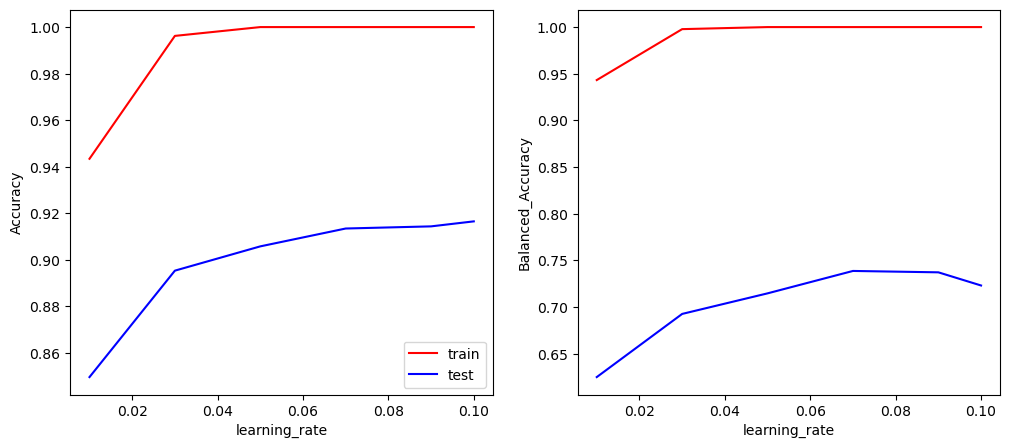

In [24]:
# learning_rate =0.1, n_estimators=8, max_depth=8,
#  min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.85,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27
from sklearn.ensemble import HistGradientBoostingClassifier
acc_train = []
acc_test = []
balanced_acc_train = []
balanced_acc_test = []
nums = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
for i in nums:
    model = HistGradientBoostingClassifier(learning_rate =i,random_state=42)
    model.fit(X_train,y_train)
    acc_train.append(model.score(X_train,y_train))
    acc_test.append(model.score(X_test,y_test))
    balanced_acc_train.append(balanced_accuracy_score(y_train, model.predict(X_train)))
    balanced_acc_test.append(balanced_accuracy_score(y_test, model.predict(X_test)))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].plot(nums,acc_train,color="red",label="train")
axes[0].plot(nums,acc_test,color="blue",label="test")
axes[0].legend()
axes[0].set_xlabel('learning_rate')
axes[0].set_ylabel('Accuracy')
axes[1].plot(nums,balanced_acc_train,color="red",label="train")
axes[1].plot(nums,balanced_acc_test,color="blue",label="test")
axes[1].set_xlabel('learning_rate')
axes[1].set_ylabel('Balanced_Accuracy')
plt.show()


In [7]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=42)
os_X_train,os_y_train=oversampler.fit_resample(X_train,y_train)

clf = HistGradientBoostingClassifier(random_state=42)

clf.fit(os_X_train, os_y_train)
train_pred = clf.predict(os_X_train)
test_pred = clf.predict(X_test)
print("Balanced Accuracy on train data: {:.4f}".format(balanced_accuracy_score(os_y_train, train_pred)))
print("Balanced Accuracy on test data: {:.4f}".format(balanced_accuracy_score(y_test, test_pred)))
print("Accuracy on test data: {:.4f}".format(clf.score(os_X_train, os_y_train)))
print("Accuracy on test data: {:.4f}".format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
#target_names = list(data['Kingdom'].unique())

print(classification_report(y_test, y_pred))

Balanced Accuracy on train data: 0.9984
Balanced Accuracy on test data: 0.7770
Accuracy on test data: 0.9984
Accuracy on test data: 0.9260
              precision    recall  f1-score   support

         arc       0.84      0.62      0.71        26
         bct       0.95      0.95      0.95       753
         inv       0.89      0.86      0.87       342
         mam       0.89      0.88      0.88       137
         phg       0.70      0.66      0.68        56
         plm       0.50      0.17      0.25         6
         pln       0.92      0.94      0.93       629
         pri       0.88      0.74      0.80        50
         rod       0.76      0.81      0.79        48
         vrl       0.93      0.96      0.95       721
         vrt       0.96      0.97      0.96       489

    accuracy                           0.93      3257
   macro avg       0.84      0.78      0.80      3257
weighted avg       0.92      0.93      0.92      3257



### clustering
尝试使用dna 频率数据做聚类分析(unsupervised),最终对所属类别作对比。
首先做数据降维？

In [49]:
data = pd.read_csv('codon_usage.csv',low_memory=False)
data = data.set_index('SpeciesID')
data['UUU'] = pd.to_numeric(data['UUU'], errors='coerce')
data['UUC'] = pd.to_numeric(data['UUC'], errors='coerce')
data.dropna(inplace=True)
X, y = data.drop(['Kingdom', 'DNAtype', 'Ncodons','SpeciesName'], axis=1), data['Kingdom'] 

In [50]:
class_labels = list(y.unique())
class_mapping = {class_label: i+1 for i, class_label in enumerate(class_labels)}
numeric_labels = [class_mapping[label] for label in y]
numeric_labels = pd.DataFrame(numeric_labels)
numeric_labels.columns = ['Numerical Kingdom']
numeric_labels.index = X.index
numeric_labels

,Numerical Kingdom
SpeciesID,
100217,1
100220,1
100755,1
100880,1
100887,1
...,...
9601,11
9601,11
9602,11


In [67]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

X_std = preprocessing.scale(X)
tsne = TSNE(n_components=2)

X_transform = tsne.fit_transform(X_std)


[[ 63.43692   -34.696312 ]
 [ 63.41716   -34.69553  ]
 [-16.288612  -88.832756 ]
 ...
 [ -1.5876503  78.10358  ]
 [ 48.031715  -47.334175 ]
 [ -1.6902733  76.57962  ]]


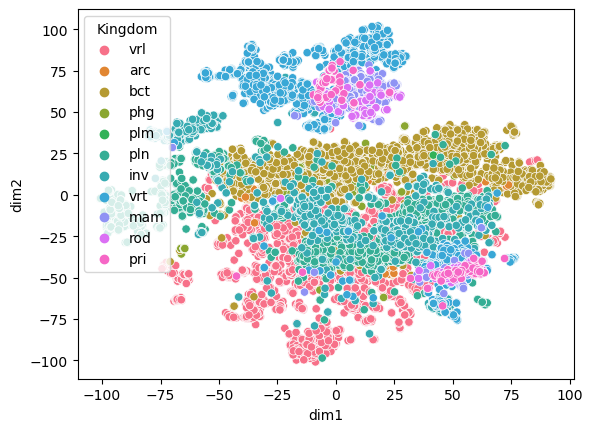

In [75]:
print(X_transform)
X_tsne = pd.DataFrame(X_transform, columns =['dim1', 'dim2'])
X_tsne.index = X.index
data_tsne = pd.concat([X_tsne, y], axis = 1)

plt.figure() 
sns.scatterplot(data=data_tsne, hue='Kingdom', x='dim1', y='dim2') 
plt.savefig('TSNE reduction')
plt.show()


<Figure size 640x480 with 0 Axes>

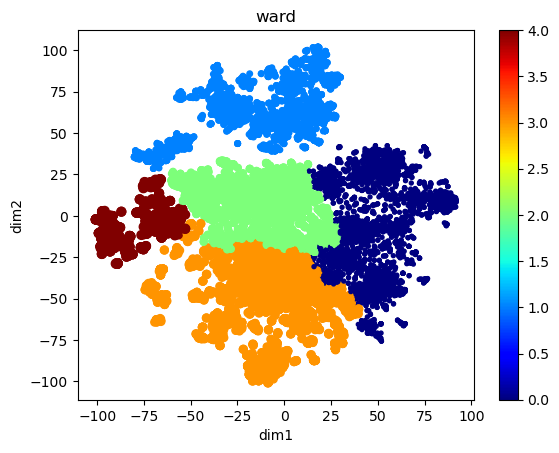

In [93]:
from sklearn.cluster import AgglomerativeClustering
data = X_tsne
linkage = 'ward'
ac = AgglomerativeClustering(linkage=linkage,n_clusters=5)
result = ac.fit(data)

plt.figure()
data.plot.scatter(x='dim1',y='dim2',colormap='jet',
                  c=result.labels_,s=(result.labels_+1)*8)
# for point in list(data.index):
#     plt.text(data.loc[point,'x'],data.loc[point,'y'],point,
#              ha='left',va='top',fontsize='xx-large')
plt.title(linkage)
plt.savefig('hierarchy')

In [86]:
X_tsne

,dim1,dim2
SpeciesID,,
100217,63.436920,-34.696312
100220,63.417160,-34.695530
100755,-16.288612,-88.832756
100880,-10.683298,-51.920498
100887,-25.201021,-23.311226
...,...,...
9601,45.008999,-52.039948
9601,-1.606533,77.797951
9602,-1.587650,78.103577


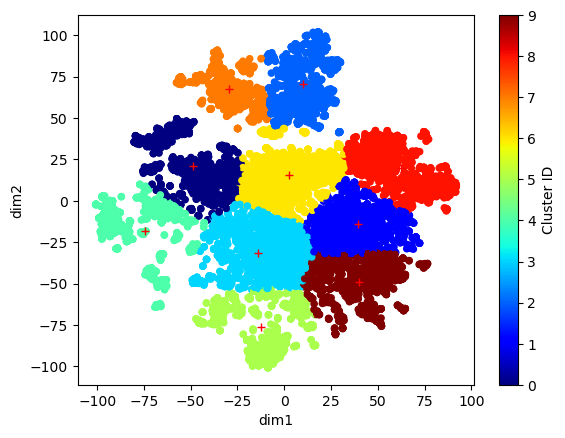

In [89]:
from sklearn import cluster
data = X_tsne

k_means = cluster.KMeans(n_clusters=10, max_iter=50, random_state=1)
k_means.fit(data)

labels = pd.DataFrame(k_means.labels_,columns=['Cluster ID'])
labels.index = data.index
result = pd.concat((data,labels), axis=1)

fig = result.plot.scatter(x='dim1',y='dim2',c='Cluster ID', colormap='jet')

xy = pd.DataFrame(k_means.cluster_centers_,columns=['x','y'])
fig.plot(xy['x'],xy['y'],'r+')

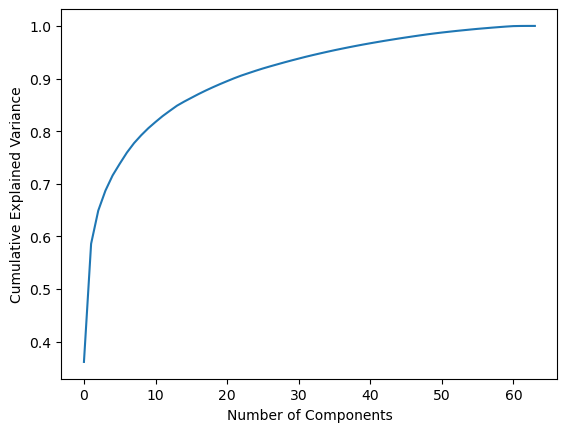

Number of components to retain 95.0% variance: 35


In [10]:
from sklearn.decomposition import PCA
# 假设 X 是你的数据
pca = PCA()
pca.fit(X)

# 绘制累积解释方差比例的图形
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

desired_variance = 0.95
numComponents = np.argmax(cumulative_variance_ratio >= desired_variance) + 1
print(f'Number of components to retain {desired_variance*100}% variance: {numComponents}')

聚类研究是不是可以剔除异常值和极值？\
聚类是否需要降维?\
聚类的标签如何和真实标签做对比\
根据聚类打的指标做有监督学习？